In [2]:
#Author: Marlon Segarra
# Proyecto de Mineria de datos
# Version 3.0
# 2do término 2018-2019
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
nltk.download('stopwords')
import string
import re
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
#import spacy
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/piero512/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Analysis of the dataset
### We examine the structure of the dataset looking for relevant columns for the analysis

In [2]:
#Visualizando la estructura del dataset
tweets=pd.read_csv('C:/Users/LENOVO/Desktop/Proyecto-Mineria/Toxic tweets dataset - annotator2.csv')
tweets.head()

,id,screen_name,latitude,longitude,in_reply_to_status_id,text,timestamp,conversation_id,conversation_deep,url,toxic,severe_toxic,obscene,threat,identity_hate,insult,target,extended,comment
0,9.411401e+17,AmiIcarCajadas,NaN,NaN,9.411397e+17,"@PabloJarrinT Delfín el Leicester criollo, cam...",2017-12-14 2:57:38,9.411397e+17,2,https://www.twitter.com/AmiIcarCajadas/status/...,0,0,0,0,0,0,@PabloJarrinT,La página no existe,NaN
1,8.512670e+17,verosanza,NaN,NaN,8.512659e+17,@Martinminguchi Desde dónde lo estará escribie...,2017-04-10 2:53:56,8.512659e+17,2,https://www.twitter.com/verosanza/status/85126...,0,0,0,0,0,0,@GuillaumeLong,Desde dónde lo estará escribiendo...Francia???...,ninguno
2,9.367120e+17,estebancarranco,NaN,NaN,9.366059e+17,@aituitu Respeto su criterio amigo pero si fue...,2017-12-01 21:41:53,9.365740e+17,3,https://www.twitter.com/estebancarranco/status...,0,0,0,0,0,0,@aituitu,"Respeto su criterio amigo pero si fuese así, n...",discrepa pero es respetuoso
3,9.619900e+17,LuisAndrade2,NaN,NaN,9.617694e+17,"@higuerahernan Creo porque ""es multi facético,...",2018-02-09 15:47:40,9.617694e+17,2,https://www.twitter.com/LuisAndrade2/status/96...,0,0,0,0,0,0,external,"Creo porque ""es multi facético, inteligente y ...",alabanza
4,9.748170e+17,VinicioChimbor1,NaN,NaN,9.744270e+17,@luisevivanco Hágase revisar la presión del oj...,2018-03-17 1:17:48,9.744270e+17,2,https://www.twitter.com/VinicioChimbor1/status...,0,0,0,0,0,0,@luisevivanco,"Hágase revisar la presión del ojo, el parpadeo...",consejo


# Harmful Speech
## We are trying to visualize different types of harmful speech in the dataset using the 6 columns present in the dataset

Text(0.5,1,'Number of Harmful Speech by category')

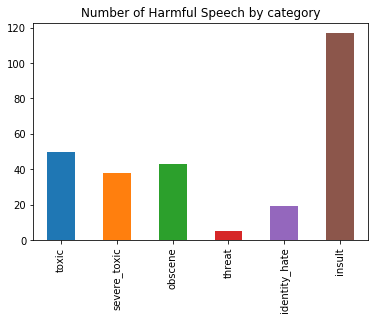

In [3]:
#identificando la cantidad de tweets etiquetados por las distintas categorias
tweets[['toxic','severe_toxic','obscene','threat','identity_hate','insult']].sum().plot.bar()
plt.title('Number of Harmful Speech by category')

## We found that the use of sentiment analysis in the tweet is not useful because the text is too short giving us values from 0 to 0.500 or -0.500

## Changing the index column we order the tweets by date looking for some aditional information that can contribute to our investigation

In [4]:
#Cambiamos el índice para poder ordenar por fecha
tweets.index=pd.to_datetime(tweets['timestamp'],infer_datetime_format=True)
tweets

,id,screen_name,latitude,longitude,in_reply_to_status_id,text,timestamp,conversation_id,conversation_deep,url,toxic,severe_toxic,obscene,threat,identity_hate,insult,target,extended,comment
timestamp,,,,,,,,,,,,,,,,,,,
2017-12-14 02:57:38,9.411401e+17,AmiIcarCajadas,NaN,NaN,9.411397e+17,"@PabloJarrinT Delfín el Leicester criollo, cam...",2017-12-14 2:57:38,9.411397e+17,2,https://www.twitter.com/AmiIcarCajadas/status/...,0,0,0,0,0,0,@PabloJarrinT,La página no existe,NaN
2017-04-10 02:53:56,8.512670e+17,verosanza,NaN,NaN,8.512659e+17,@Martinminguchi Desde dónde lo estará escribie...,2017-04-10 2:53:56,8.512659e+17,2,https://www.twitter.com/verosanza/status/85126...,0,0,0,0,0,0,@GuillaumeLong,Desde dónde lo estará escribiendo...Francia???...,ninguno
2017-12-01 21:41:53,9.367120e+17,estebancarranco,NaN,NaN,9.366059e+17,@aituitu Respeto su criterio amigo pero si fue...,2017-12-01 21:41:53,9.365740e+17,3,https://www.twitter.com/estebancarranco/status...,0,0,0,0,0,0,@aituitu,"Respeto su criterio amigo pero si fuese así, n...",discrepa pero es respetuoso
2018-02-09 15:47:40,9.619900e+17,LuisAndrade2,NaN,NaN,9.617694e+17,"@higuerahernan Creo porque ""es multi facético,...",2018-02-09 15:47:40,9.617694e+17,2,https://www.twitter.com/LuisAndrade2/status/96...,0,0,0,0,0,0,external,"Creo porque ""es multi facético, inteligente y ...",alabanza
2018-03-17 01:17:48,9.748170e+17,VinicioChimbor1,NaN,NaN,9.744270e+17,@luisevivanco Hágase revisar la presión del oj...,2018-03-17 1:17:48,9.744270e+17,2,https://www.twitter.com/VinicioChimbor1/status...,0,0,0,0,0,0,@luisevivanco,"Hágase revisar la presión del ojo, el parpadeo...",consejo
2018-01-15 16:52:55,9.529467e+17,DavidAndres27,NaN,NaN,9.523808e+17,@jcarlosaizprua #ImbaburaDiceNO y todo el Ecua...,2018-01-15 16:52:55,9.523808e+17,2,https://www.twitter.com/DavidAndres27/status/9...,0,0,0,0,0,0,external,#ImbaburaDiceNO y todo el Ecuador no se deja e...,polìtico
2017-09-25 03:04:28,9.121508e+17,CarlosVerareal,NaN,NaN,NaN,Pendejo. Perdido. Sin argumentos. https://t.co...,2017-09-25 3:04:28,9.121508e+17,1,https://www.twitter.com/CarlosVerareal/status/...,0,0,0,0,0,1,external,Pendejo. Perdido. Sin argumentos.,insulto
2018-02-01 03:33:56,9.589062e+17,savirosero,NaN,NaN,9.588601e+17,@marcelaholguin @UNIMAXTV @SomosEcuador3 @Dile...,2018-02-01 3:33:56,9.588601e+17,2,https://www.twitter.com/savirosero/status/9589...,0,0,0,0,0,1,external,Mijita con esos apagones del CNE solo idiotas ...,insulto
2017-12-07 13:32:31,9.387632e+17,Martinminguchi,NaN,NaN,NaN,Orden de Prisión en contra de Cristina Elisabe...,2017-12-07 13:32:31,9.387632e+17,1,https://www.twitter.com/Martinminguchi/status/...,0,0,0,0,0,0,na,Orden de Prisión en contra de Cristina Elisabe...,NaN


## We obained the number of tweets by weekday, this brings us information about the days where the people write more

Text(0.5,1,'Frequency of tweets by weekday')

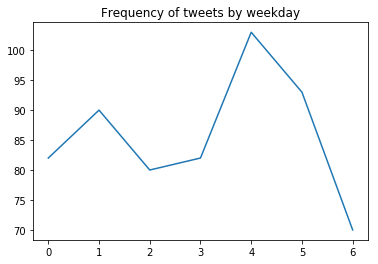

In [5]:
#Ordenamos los tweets por dia de la semana en donde 0 es Domingo y 6 es Sábado
tweets=tweets.sort_index(ascending=True)
tweets.index.weekday.value_counts().sort_index().plot()
plt.title('Frequency of tweets by weekday')

Text(0.5,1,'Frequency of tweets by month')

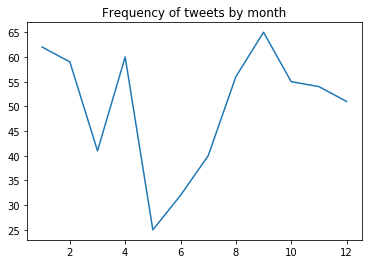

In [6]:
#Visualizamos la frecuencia de los tweets por mes
tweets=tweets.sort_index(ascending=True)
tweets.index.month.value_counts().sort_index().plot()
plt.title('Frequency of tweets by month')

Text(0.5,1,'Frequency of tweets by year')

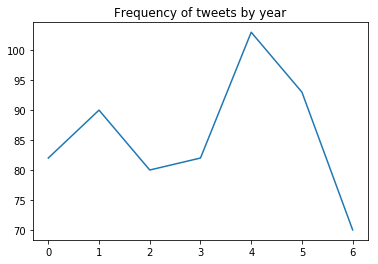

In [7]:
# Visualizamos la frecuencia de los tweets por año
tweets=tweets.sort_index(ascending=True)
tweets.index.weekday.value_counts().sort_index().plot()
plt.title('Frequency of tweets by year')

Text(0.5,1,'Frequency of tweets by month(2018)')

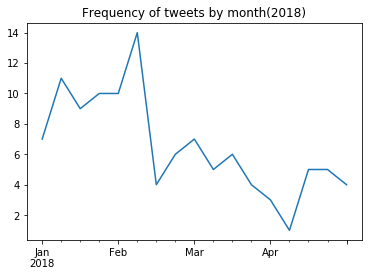

In [8]:
# Visualizamos la distribucion de los tweet en el año 2018 por mes
tweets['2018-01-01':'2018-12-31'].index.value_counts().sort_index().resample('w').sum().plot()
plt.title('Frequency of tweets by month(2018)')

Text(0.5,1,'Frequency of tweets by month(2014)')

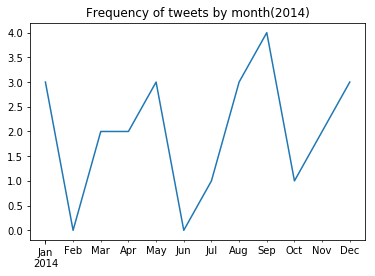

In [9]:
# Visualizamos la frecuencia de los tweets del año 2014 
tweets['2014-01-01':'2014-12-31'].index.value_counts().sort_index().resample('M').sum().plot()
plt.title('Frequency of tweets by month(2014)')

# Aplying LDA


In [15]:
#Función utilizada para extraer las menciones de los tweets
def extract_mentions(tweet):
    '''Given a tweet, this function returns the user mentions'''
    mentions = []
    if len(re.findall('@[^\s@]+', tweet))>0:
        mentions.append(re.findall('@([^\s@]+)', tweet))
    else:
        mentions.append(["0"])
    return mentions[0]

# Ubica las menciones de cada tweet en una columna del dataframe
tweets['user_mentions'] = tweets['text'].map(extract_mentions)
tweets.head(10)

<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:6: Dep

,id,screen_name,latitude,longitude,in_reply_to_status_id,text,timestamp,conversation_id,conversation_deep,url,toxic,severe_toxic,obscene,threat,identity_hate,insult,target,extended,comment,user_mentions
timestamp,,,,,,,,,,,,,,,,,,,,
2012-01-28 16:10:53,1.632930e+17,LeninArtieda,NaN,NaN,NaN,@DiegowMM bajaron de Ciudad Alfaro a Montecris...,2012-01-28 16:10:53,1.632930e+17,1,https://www.twitter.com/LeninArtieda/status/16...,0,0,0,0,0,0,na,@DiegowMM bajaron de Ciudad Alfaro a Montecris...,NaN,[DiegowMM]
2012-01-28 16:19:50,1.632952e+17,javi_300,NaN,NaN,1.632858e+17,@LeninArtieda @JoseYcaza Me parece raro que ha...,2012-01-28 16:19:50,1.632842e+17,4,https://www.twitter.com/javi_300/status/163295...,0,0,0,0,0,0,@LeninArtieda,@LeninArtieda @JoseYcaza Me parece raro que ha...,NaN,"[LeninArtieda, JoseYcaza]"
2012-07-23 16:52:04,2.274460e+17,ElGuille1981,NaN,NaN,2.274399e+17,@andresitorres8 @aguschmer jajaja estamos en l...,2012-07-23 16:52:04,2.274387e+17,3,https://www.twitter.com/ElGuille1981/status/22...,0,0,0,0,0,1,external,@andresitorres8 @aguschmer jajaja estamos en l...,NaN,"[andresitorres8, aguschmer]"
2012-07-30 21:08:59,2.300474e+17,OmarVLuna,NaN,NaN,NaN,Bien Gongora!!!,2012-07-30 21:08:59,2.300474e+17,1,https://www.twitter.com/OmarVLuna/status/23004...,0,0,0,0,0,0,external,Bien Gongora!!!,NaN,[0]
2012-08-12 23:33:07,2.347947e+17,Ceagd,NaN,NaN,2.347929e+17,RT @RobertoBonafont: Arroyo gana pelota a Gimé...,2012-08-12 23:33:07,2.347929e+17,2,https://www.twitter.com/Ceagd/status/234794677...,0,0,0,0,0,0,@RobertoBonafont,RT @RobertoBonafont: Arroyo gana pelota a Gimé...,NaN,[RobertoBonafont:]
2012-09-23 19:51:49,2.499593e+17,williamludena,NaN,NaN,2.499587e+17,@Pichi_Mendoza Saludos hermano!,2012-09-23 19:51:49,2.499465e+17,7,https://www.twitter.com/williamludena/status/2...,0,0,0,0,0,0,@Pichi_Mendoza,@Pichi_Mendoza Saludos hermano!,NaN,[Pichi_Mendoza]
2012-10-10 11:39:41,2.559960e+17,rhernandeztv,NaN,NaN,NaN,"Glad to hear fom you, @Begumdonmez",2012-10-10 11:39:41,2.559960e+17,1,https://www.twitter.com/rhernandeztv/status/25...,0,0,0,0,0,0,external,"Glad to hear fom you, @Begumdonmez",saludo,[Begumdonmez]
2013-02-24 01:03:20,3.054830e+17,egasic,NaN,NaN,3.054825e+17,@xaviercoellob @tononoboa @LuchoNoboaYcaza de ...,2013-02-24 1:03:20,3.054825e+17,2,https://www.twitter.com/egasic/status/30548301...,1,0,0,0,0,0,external,@xaviercoellob @tononoboa @LuchoNoboaYcaza de ...,NaN,"[xaviercoellob, tononoboa, LuchoNoboaYcaza]"
2013-04-11 12:30:24,3.223258e+17,ivonnelago,NaN,NaN,NaN,Para ser estúpido y descriteriado no se necesi...,2013-04-11 12:30:24,3.223258e+17,1,https://www.twitter.com/ivonnelago/status/3223...,0,0,0,0,0,1,external,Para ser estúpido y descriteriado no se necesi...,NaN,[0]


In [16]:
#Funcion utilizada para remover las menciones del tweet
def remove_mentions(tweet):
    '''Given a text, remove the user mentions'''
    mentions = []
    if len(re.findall('@[^\s@]+', tweet))>0:
        tweet = re.sub('@[^\s@]+', "" , tweet)
        mentions.append(tweet)
    else:
        mentions.append(tweet)
    return mentions[0]
# Actualiza la columna del dataframe con el tweet sin las menciones
tweets['text'] = tweets['text'].map(remove_mentions)
tweets.head(10)

<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:6: Dep

,id,screen_name,latitude,longitude,in_reply_to_status_id,text,timestamp,conversation_id,conversation_deep,url,toxic,severe_toxic,obscene,threat,identity_hate,insult,target,extended,comment,user_mentions
timestamp,,,,,,,,,,,,,,,,,,,,
2012-01-28 16:10:53,1.632930e+17,LeninArtieda,NaN,NaN,NaN,bajaron de Ciudad Alfaro a Montecristi. Algun...,2012-01-28 16:10:53,1.632930e+17,1,https://www.twitter.com/LeninArtieda/status/16...,0,0,0,0,0,0,na,@DiegowMM bajaron de Ciudad Alfaro a Montecris...,NaN,[DiegowMM]
2012-01-28 16:19:50,1.632952e+17,javi_300,NaN,NaN,1.632858e+17,Me parece raro que hayan planificado un show...,2012-01-28 16:19:50,1.632842e+17,4,https://www.twitter.com/javi_300/status/163295...,0,0,0,0,0,0,@LeninArtieda,@LeninArtieda @JoseYcaza Me parece raro que ha...,NaN,"[LeninArtieda, JoseYcaza]"
2012-07-23 16:52:04,2.274460e+17,ElGuille1981,NaN,NaN,2.274399e+17,"jajaja estamos en la mierda, maldita llegada...",2012-07-23 16:52:04,2.274387e+17,3,https://www.twitter.com/ElGuille1981/status/22...,0,0,0,0,0,1,external,@andresitorres8 @aguschmer jajaja estamos en l...,NaN,"[andresitorres8, aguschmer]"
2012-07-30 21:08:59,2.300474e+17,OmarVLuna,NaN,NaN,NaN,Bien Gongora!!!,2012-07-30 21:08:59,2.300474e+17,1,https://www.twitter.com/OmarVLuna/status/23004...,0,0,0,0,0,0,external,Bien Gongora!!!,NaN,[0]
2012-08-12 23:33:07,2.347947e+17,Ceagd,NaN,NaN,2.347929e+17,RT Arroyo gana pelota a Giménez y Gol de Díaz...,2012-08-12 23:33:07,2.347929e+17,2,https://www.twitter.com/Ceagd/status/234794677...,0,0,0,0,0,0,@RobertoBonafont,RT @RobertoBonafont: Arroyo gana pelota a Gimé...,NaN,[RobertoBonafont:]
2012-09-23 19:51:49,2.499593e+17,williamludena,NaN,NaN,2.499587e+17,Saludos hermano!,2012-09-23 19:51:49,2.499465e+17,7,https://www.twitter.com/williamludena/status/2...,0,0,0,0,0,0,@Pichi_Mendoza,@Pichi_Mendoza Saludos hermano!,NaN,[Pichi_Mendoza]
2012-10-10 11:39:41,2.559960e+17,rhernandeztv,NaN,NaN,NaN,"Glad to hear fom you,",2012-10-10 11:39:41,2.559960e+17,1,https://www.twitter.com/rhernandeztv/status/25...,0,0,0,0,0,0,external,"Glad to hear fom you, @Begumdonmez",saludo,[Begumdonmez]
2013-02-24 01:03:20,3.054830e+17,egasic,NaN,NaN,3.054825e+17,de q vale la libertadores si en el campeona...,2013-02-24 1:03:20,3.054825e+17,2,https://www.twitter.com/egasic/status/30548301...,1,0,0,0,0,0,external,@xaviercoellob @tononoboa @LuchoNoboaYcaza de ...,NaN,"[xaviercoellob, tononoboa, LuchoNoboaYcaza]"
2013-04-11 12:30:24,3.223258e+17,ivonnelago,NaN,NaN,NaN,Para ser estúpido y descriteriado no se necesi...,2013-04-11 12:30:24,3.223258e+17,1,https://www.twitter.com/ivonnelago/status/3223...,0,0,0,0,0,1,external,Para ser estúpido y descriteriado no se necesi...,NaN,[0]


In [17]:
#Funcion utilizada para remover los signos de puntuación
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text
#Creación de una nueva columna con el tweet sin signos de puntuación
tweets['Tweet_punct'] = tweets['text'].apply(lambda x: remove_punct(x))
sid = SentimentIntensityAnalyzer() 
# Creación de una nueva columna con el valor de sentimiento del tweet
tweets["sentiment"] = tweets["text"].apply(lambda x: sid.polarity_scores(x)["compound"])
tweets
tweets.head(10)

,id,screen_name,latitude,longitude,in_reply_to_status_id,text,timestamp,conversation_id,conversation_deep,url,...,obscene,threat,identity_hate,insult,target,extended,comment,user_mentions,Tweet_punct,sentiment
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-01-28 16:10:53,1.632930e+17,LeninArtieda,NaN,NaN,NaN,bajaron de Ciudad Alfaro a Montecristi. Algun...,2012-01-28 16:10:53,1.632930e+17,1,https://www.twitter.com/LeninArtieda/status/16...,...,0,0,0,0,na,@DiegowMM bajaron de Ciudad Alfaro a Montecris...,NaN,[DiegowMM],bajaron de Ciudad Alfaro a Montecristi Alguno...,0.0000
2012-01-28 16:19:50,1.632952e+17,javi_300,NaN,NaN,1.632858e+17,Me parece raro que hayan planificado un show...,2012-01-28 16:19:50,1.632842e+17,4,https://www.twitter.com/javi_300/status/163295...,...,0,0,0,0,@LeninArtieda,@LeninArtieda @JoseYcaza Me parece raro que ha...,NaN,"[LeninArtieda, JoseYcaza]",Me parece raro que hayan planificado un show...,0.0000
2012-07-23 16:52:04,2.274460e+17,ElGuille1981,NaN,NaN,2.274399e+17,"jajaja estamos en la mierda, maldita llegada...",2012-07-23 16:52:04,2.274387e+17,3,https://www.twitter.com/ElGuille1981/status/22...,...,0,0,0,1,external,@andresitorres8 @aguschmer jajaja estamos en l...,NaN,"[andresitorres8, aguschmer]",jajaja estamos en la mierda maldita llegada ...,0.0000
2012-07-30 21:08:59,2.300474e+17,OmarVLuna,NaN,NaN,NaN,Bien Gongora!!!,2012-07-30 21:08:59,2.300474e+17,1,https://www.twitter.com/OmarVLuna/status/23004...,...,0,0,0,0,external,Bien Gongora!!!,NaN,[0],Bien Gongora,0.0000
2012-08-12 23:33:07,2.347947e+17,Ceagd,NaN,NaN,2.347929e+17,RT Arroyo gana pelota a Giménez y Gol de Díaz...,2012-08-12 23:33:07,2.347929e+17,2,https://www.twitter.com/Ceagd/status/234794677...,...,0,0,0,0,@RobertoBonafont,RT @RobertoBonafont: Arroyo gana pelota a Gimé...,NaN,[RobertoBonafont:],RT Arroyo gana pelota a Giménez y Gol de Díaz...,0.0000
2012-09-23 19:51:49,2.499593e+17,williamludena,NaN,NaN,2.499587e+17,Saludos hermano!,2012-09-23 19:51:49,2.499465e+17,7,https://www.twitter.com/williamludena/status/2...,...,0,0,0,0,@Pichi_Mendoza,@Pichi_Mendoza Saludos hermano!,NaN,[Pichi_Mendoza],Saludos hermano,0.0000
2012-10-10 11:39:41,2.559960e+17,rhernandeztv,NaN,NaN,NaN,"Glad to hear fom you,",2012-10-10 11:39:41,2.559960e+17,1,https://www.twitter.com/rhernandeztv/status/25...,...,0,0,0,0,external,"Glad to hear fom you, @Begumdonmez",saludo,[Begumdonmez],Glad to hear fom you,0.4588
2013-02-24 01:03:20,3.054830e+17,egasic,NaN,NaN,3.054825e+17,de q vale la libertadores si en el campeona...,2013-02-24 1:03:20,3.054825e+17,2,https://www.twitter.com/egasic/status/30548301...,...,0,0,0,0,external,@xaviercoellob @tononoboa @LuchoNoboaYcaza de ...,NaN,"[xaviercoellob, tononoboa, LuchoNoboaYcaza]",de q vale la libertadores si en el campeona...,0.0000
2013-04-11 12:30:24,3.223258e+17,ivonnelago,NaN,NaN,NaN,Para ser estúpido y descriteriado no se necesi...,2013-04-11 12:30:24,3.223258e+17,1,https://www.twitter.com/ivonnelago/status/3223...,...,0,0,0,1,external,Para ser estúpido y descriteriado no se necesi...,NaN,[0],Para ser estúpido y descriteriado no se necesi...,-0.2960


In [18]:
#Funcion utilizada para realizar la tokenización
def tokenization(text):
    text = re.split('\W+', text)
    return text

#Creación de nueva columna con el tweet una vez aplicada la función anterior
tweets['Tweet_tokenized'] = tweets['Tweet_punct'].apply(lambda x: tokenization(x.lower()))
tweets.head()

<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: Dep

,id,screen_name,latitude,longitude,in_reply_to_status_id,text,timestamp,conversation_id,conversation_deep,url,...,threat,identity_hate,insult,target,extended,comment,user_mentions,Tweet_punct,sentiment,Tweet_tokenized
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-01-28 16:10:53,1.632930e+17,LeninArtieda,NaN,NaN,NaN,bajaron de Ciudad Alfaro a Montecristi. Algun...,2012-01-28 16:10:53,1.632930e+17,1,https://www.twitter.com/LeninArtieda/status/16...,...,0,0,0,na,@DiegowMM bajaron de Ciudad Alfaro a Montecris...,NaN,[DiegowMM],bajaron de Ciudad Alfaro a Montecristi Alguno...,0.0,"[, bajaron, de, ciudad, alfaro, a, montecristi..."
2012-01-28 16:19:50,1.632952e+17,javi_300,NaN,NaN,1.632858e+17,Me parece raro que hayan planificado un show...,2012-01-28 16:19:50,1.632842e+17,4,https://www.twitter.com/javi_300/status/163295...,...,0,0,0,@LeninArtieda,@LeninArtieda @JoseYcaza Me parece raro que ha...,NaN,"[LeninArtieda, JoseYcaza]",Me parece raro que hayan planificado un show...,0.0,"[, me, parece, raro, que, hayan, planificado, ..."
2012-07-23 16:52:04,2.274460e+17,ElGuille1981,NaN,NaN,2.274399e+17,"jajaja estamos en la mierda, maldita llegada...",2012-07-23 16:52:04,2.274387e+17,3,https://www.twitter.com/ElGuille1981/status/22...,...,0,0,1,external,@andresitorres8 @aguschmer jajaja estamos en l...,NaN,"[andresitorres8, aguschmer]",jajaja estamos en la mierda maldita llegada ...,0.0,"[, jajaja, estamos, en, la, mierda, maldita, l..."
2012-07-30 21:08:59,2.300474e+17,OmarVLuna,NaN,NaN,NaN,Bien Gongora!!!,2012-07-30 21:08:59,2.300474e+17,1,https://www.twitter.com/OmarVLuna/status/23004...,...,0,0,0,external,Bien Gongora!!!,NaN,[0],Bien Gongora,0.0,"[bien, gongora]"
2012-08-12 23:33:07,2.347947e+17,Ceagd,NaN,NaN,2.347929e+17,RT Arroyo gana pelota a Giménez y Gol de Díaz...,2012-08-12 23:33:07,2.347929e+17,2,https://www.twitter.com/Ceagd/status/234794677...,...,0,0,0,@RobertoBonafont,RT @RobertoBonafont: Arroyo gana pelota a Gimé...,NaN,[RobertoBonafont:],RT Arroyo gana pelota a Giménez y Gol de Díaz...,0.0,"[rt, arroyo, gana, pelota, a, giménez, y, gol,..."


In [19]:
# Definimos los stopwords adicionales del idioma a utilizar
stopword = nltk.corpus.stopwords.words('spanish')
stopword.extend(['d','x','q','bla','rt','ab','xq','ma'])

#Función para remover los stopwords de tweet
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
# Nueva columna con los tweets sin stopwords    
tweets['Tweet_nonstop'] = tweets['Tweet_tokenized'].apply(lambda x: remove_stopwords(x))
tweets.head(10)

,id,screen_name,latitude,longitude,in_reply_to_status_id,text,timestamp,conversation_id,conversation_deep,url,...,identity_hate,insult,target,extended,comment,user_mentions,Tweet_punct,sentiment,Tweet_tokenized,Tweet_nonstop
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-01-28 16:10:53,1.632930e+17,LeninArtieda,NaN,NaN,NaN,bajaron de Ciudad Alfaro a Montecristi. Algun...,2012-01-28 16:10:53,1.632930e+17,1,https://www.twitter.com/LeninArtieda/status/16...,...,0,0,na,@DiegowMM bajaron de Ciudad Alfaro a Montecris...,NaN,[DiegowMM],bajaron de Ciudad Alfaro a Montecristi Alguno...,0.0000,"[, bajaron, de, ciudad, alfaro, a, montecristi...","[, bajaron, ciudad, alfaro, montecristi, queda..."
2012-01-28 16:19:50,1.632952e+17,javi_300,NaN,NaN,1.632858e+17,Me parece raro que hayan planificado un show...,2012-01-28 16:19:50,1.632842e+17,4,https://www.twitter.com/javi_300/status/163295...,...,0,0,@LeninArtieda,@LeninArtieda @JoseYcaza Me parece raro que ha...,NaN,"[LeninArtieda, JoseYcaza]",Me parece raro que hayan planificado un show...,0.0000,"[, me, parece, raro, que, hayan, planificado, ...","[, parece, raro, planificado, show, mismo, tie..."
2012-07-23 16:52:04,2.274460e+17,ElGuille1981,NaN,NaN,2.274399e+17,"jajaja estamos en la mierda, maldita llegada...",2012-07-23 16:52:04,2.274387e+17,3,https://www.twitter.com/ElGuille1981/status/22...,...,0,1,external,@andresitorres8 @aguschmer jajaja estamos en l...,NaN,"[andresitorres8, aguschmer]",jajaja estamos en la mierda maldita llegada ...,0.0000,"[, jajaja, estamos, en, la, mierda, maldita, l...","[, jajaja, mierda, maldita, llegada, ]"
2012-07-30 21:08:59,2.300474e+17,OmarVLuna,NaN,NaN,NaN,Bien Gongora!!!,2012-07-30 21:08:59,2.300474e+17,1,https://www.twitter.com/OmarVLuna/status/23004...,...,0,0,external,Bien Gongora!!!,NaN,[0],Bien Gongora,0.0000,"[bien, gongora]","[bien, gongora]"
2012-08-12 23:33:07,2.347947e+17,Ceagd,NaN,NaN,2.347929e+17,RT Arroyo gana pelota a Giménez y Gol de Díaz...,2012-08-12 23:33:07,2.347929e+17,2,https://www.twitter.com/Ceagd/status/234794677...,...,0,0,@RobertoBonafont,RT @RobertoBonafont: Arroyo gana pelota a Gimé...,NaN,[RobertoBonafont:],RT Arroyo gana pelota a Giménez y Gol de Díaz...,0.0000,"[rt, arroyo, gana, pelota, a, giménez, y, gol,...","[arroyo, gana, pelota, giménez, gol, díaz, lej..."
2012-09-23 19:51:49,2.499593e+17,williamludena,NaN,NaN,2.499587e+17,Saludos hermano!,2012-09-23 19:51:49,2.499465e+17,7,https://www.twitter.com/williamludena/status/2...,...,0,0,@Pichi_Mendoza,@Pichi_Mendoza Saludos hermano!,NaN,[Pichi_Mendoza],Saludos hermano,0.0000,"[, saludos, hermano]","[, saludos, hermano]"
2012-10-10 11:39:41,2.559960e+17,rhernandeztv,NaN,NaN,NaN,"Glad to hear fom you,",2012-10-10 11:39:41,2.559960e+17,1,https://www.twitter.com/rhernandeztv/status/25...,...,0,0,external,"Glad to hear fom you, @Begumdonmez",saludo,[Begumdonmez],Glad to hear fom you,0.4588,"[glad, to, hear, fom, you, ]","[glad, to, hear, fom, you, ]"
2013-02-24 01:03:20,3.054830e+17,egasic,NaN,NaN,3.054825e+17,de q vale la libertadores si en el campeona...,2013-02-24 1:03:20,3.054825e+17,2,https://www.twitter.com/egasic/status/30548301...,...,0,0,external,@xaviercoellob @tononoboa @LuchoNoboaYcaza de ...,NaN,"[xaviercoellob, tononoboa, LuchoNoboaYcaza]",de q vale la libertadores si en el campeona...,0.0000,"[, de, q, vale, la, libertadores, si, en, el, ...","[, vale, libertadores, si, campeonato, stamos,..."
2013-04-11 12:30:24,3.223258e+17,ivonnelago,NaN,NaN,NaN,Para ser estúpido y descriteriado no se necesi...,2013-04-11 12:30:24,3.223258e+17,1,https://www.twitter.com/ivonnelago/status/3223...,...,0,1,external,Para ser estúpido y descriteriado no se necesi...,NaN,[0],Para ser estúpido y descriteriado no se necesi...,-0.2960,"[para, ser, estúpido, y, descriteriado, no, se...","[ser, estúpido, descriteriado, necesita, estud..."


In [20]:
ps = nltk.PorterStemmer()
# Función para aplicas stemming al tweet
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

# Nueva columna luego de aplicar la función creada
tweets['Tweet_stemmed'] = tweets['Tweet_nonstop'].apply(lambda x: stemming(x))
tweets.head()

,id,screen_name,latitude,longitude,in_reply_to_status_id,text,timestamp,conversation_id,conversation_deep,url,...,insult,target,extended,comment,user_mentions,Tweet_punct,sentiment,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-01-28 16:10:53,1.632930e+17,LeninArtieda,NaN,NaN,NaN,bajaron de Ciudad Alfaro a Montecristi. Algun...,2012-01-28 16:10:53,1.632930e+17,1,https://www.twitter.com/LeninArtieda/status/16...,...,0,na,@DiegowMM bajaron de Ciudad Alfaro a Montecris...,NaN,[DiegowMM],bajaron de Ciudad Alfaro a Montecristi Alguno...,0.0,"[, bajaron, de, ciudad, alfaro, a, montecristi...","[, bajaron, ciudad, alfaro, montecristi, queda...","[, bajaron, ciudad, alfaro, montecristi, queda..."
2012-01-28 16:19:50,1.632952e+17,javi_300,NaN,NaN,1.632858e+17,Me parece raro que hayan planificado un show...,2012-01-28 16:19:50,1.632842e+17,4,https://www.twitter.com/javi_300/status/163295...,...,0,@LeninArtieda,@LeninArtieda @JoseYcaza Me parece raro que ha...,NaN,"[LeninArtieda, JoseYcaza]",Me parece raro que hayan planificado un show...,0.0,"[, me, parece, raro, que, hayan, planificado, ...","[, parece, raro, planificado, show, mismo, tie...","[, parec, raro, planificado, show, mismo, tiem..."
2012-07-23 16:52:04,2.274460e+17,ElGuille1981,NaN,NaN,2.274399e+17,"jajaja estamos en la mierda, maldita llegada...",2012-07-23 16:52:04,2.274387e+17,3,https://www.twitter.com/ElGuille1981/status/22...,...,1,external,@andresitorres8 @aguschmer jajaja estamos en l...,NaN,"[andresitorres8, aguschmer]",jajaja estamos en la mierda maldita llegada ...,0.0,"[, jajaja, estamos, en, la, mierda, maldita, l...","[, jajaja, mierda, maldita, llegada, ]","[, jajaja, mierda, maldita, llegada, ]"
2012-07-30 21:08:59,2.300474e+17,OmarVLuna,NaN,NaN,NaN,Bien Gongora!!!,2012-07-30 21:08:59,2.300474e+17,1,https://www.twitter.com/OmarVLuna/status/23004...,...,0,external,Bien Gongora!!!,NaN,[0],Bien Gongora,0.0,"[bien, gongora]","[bien, gongora]","[bien, gongora]"
2012-08-12 23:33:07,2.347947e+17,Ceagd,NaN,NaN,2.347929e+17,RT Arroyo gana pelota a Giménez y Gol de Díaz...,2012-08-12 23:33:07,2.347929e+17,2,https://www.twitter.com/Ceagd/status/234794677...,...,0,@RobertoBonafont,RT @RobertoBonafont: Arroyo gana pelota a Gimé...,NaN,[RobertoBonafont:],RT Arroyo gana pelota a Giménez y Gol de Díaz...,0.0,"[rt, arroyo, gana, pelota, a, giménez, y, gol,...","[arroyo, gana, pelota, giménez, gol, díaz, lej...","[arroyo, gana, pelota, giménez, gol, díaz, lej..."


In [21]:
wn = nltk.WordNetLemmatizer()
# Función utilizada para aplicar lematización al tweet
def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text if "ja" not in word]
    return text

# Nueva columna creada aplicando la función definida anteriormente    
tweets['Tweet_lemmatized'] = tweets['Tweet_nonstop'].apply(lambda x: lemmatizer(x))
tweets.head()

,id,screen_name,latitude,longitude,in_reply_to_status_id,text,timestamp,conversation_id,conversation_deep,url,...,target,extended,comment,user_mentions,Tweet_punct,sentiment,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-01-28 16:10:53,1.632930e+17,LeninArtieda,NaN,NaN,NaN,bajaron de Ciudad Alfaro a Montecristi. Algun...,2012-01-28 16:10:53,1.632930e+17,1,https://www.twitter.com/LeninArtieda/status/16...,...,na,@DiegowMM bajaron de Ciudad Alfaro a Montecris...,NaN,[DiegowMM],bajaron de Ciudad Alfaro a Montecristi Alguno...,0.0,"[, bajaron, de, ciudad, alfaro, a, montecristi...","[, bajaron, ciudad, alfaro, montecristi, queda...","[, bajaron, ciudad, alfaro, montecristi, queda...","[, ciudad, alfaro, montecristi, quedaron, escu..."
2012-01-28 16:19:50,1.632952e+17,javi_300,NaN,NaN,1.632858e+17,Me parece raro que hayan planificado un show...,2012-01-28 16:19:50,1.632842e+17,4,https://www.twitter.com/javi_300/status/163295...,...,@LeninArtieda,@LeninArtieda @JoseYcaza Me parece raro que ha...,NaN,"[LeninArtieda, JoseYcaza]",Me parece raro que hayan planificado un show...,0.0,"[, me, parece, raro, que, hayan, planificado, ...","[, parece, raro, planificado, show, mismo, tie...","[, parec, raro, planificado, show, mismo, tiem...","[, parece, raro, planificado, show, mismo, tie..."
2012-07-23 16:52:04,2.274460e+17,ElGuille1981,NaN,NaN,2.274399e+17,"jajaja estamos en la mierda, maldita llegada...",2012-07-23 16:52:04,2.274387e+17,3,https://www.twitter.com/ElGuille1981/status/22...,...,external,@andresitorres8 @aguschmer jajaja estamos en l...,NaN,"[andresitorres8, aguschmer]",jajaja estamos en la mierda maldita llegada ...,0.0,"[, jajaja, estamos, en, la, mierda, maldita, l...","[, jajaja, mierda, maldita, llegada, ]","[, jajaja, mierda, maldita, llegada, ]","[, mierda, maldita, llegada, ]"
2012-07-30 21:08:59,2.300474e+17,OmarVLuna,NaN,NaN,NaN,Bien Gongora!!!,2012-07-30 21:08:59,2.300474e+17,1,https://www.twitter.com/OmarVLuna/status/23004...,...,external,Bien Gongora!!!,NaN,[0],Bien Gongora,0.0,"[bien, gongora]","[bien, gongora]","[bien, gongora]","[bien, gongora]"
2012-08-12 23:33:07,2.347947e+17,Ceagd,NaN,NaN,2.347929e+17,RT Arroyo gana pelota a Giménez y Gol de Díaz...,2012-08-12 23:33:07,2.347929e+17,2,https://www.twitter.com/Ceagd/status/234794677...,...,@RobertoBonafont,RT @RobertoBonafont: Arroyo gana pelota a Gimé...,NaN,[RobertoBonafont:],RT Arroyo gana pelota a Giménez y Gol de Díaz...,0.0,"[rt, arroyo, gana, pelota, a, giménez, y, gol,...","[arroyo, gana, pelota, giménez, gol, díaz, lej...","[arroyo, gana, pelota, giménez, gol, díaz, lej...","[arroyo, gana, pelota, giménez, gol, díaz, der..."


In [22]:
#Función para obtener el texto sin signos de puntiación, tokenizado, con stemming y sin stopwords
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text

countVectorizer = CountVectorizer(analyzer=clean_text) 
countVector = countVectorizer.fit_transform(tweets['text'])
print('{} Number of tweets has {} words'.format(countVector.shape[0], countVector.shape[1]))

600 Number of tweets has 2468 words


<input>:5: DeprecationWarning: invalid escape sequence \W
<input>:5: DeprecationWarning: invalid escape sequence \W
<input>:5: DeprecationWarning: invalid escape sequence \W
<input>:5: DeprecationWarning: invalid escape sequence \W
<input>:5: DeprecationWarning: invalid escape sequence \W
<input>:5: DeprecationWarning: invalid escape sequence \W
<input>:5: DeprecationWarning: invalid escape sequence \W
<input>:5: DeprecationWarning: invalid escape sequence \W
<input>:5: DeprecationWarning: invalid escape sequence \W
<input>:5: DeprecationWarning: invalid escape sequence \W
<input>:5: DeprecationWarning: invalid escape sequence \W
<input>:5: DeprecationWarning: invalid escape sequence \W
<input>:5: DeprecationWarning: invalid escape sequence \W
<input>:5: DeprecationWarning: invalid escape sequence \W
<input>:5: DeprecationWarning: invalid escape sequence \W
<input>:5: DeprecationWarning: invalid escape sequence \W
<input>:5: DeprecationWarning: invalid escape sequence \W
<input>:5: Dep

In [23]:
# Creación de un nuevo dataframe con las palabras de los tweets
count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())
count_vect_df.head()

,,abandona,abierto,abogado,abrazo,abril,abrumadora,absoluto,abuela,abusivo,...,ávila,época,éstabernard,éste,ética,éxito,ósea,última,último,único
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


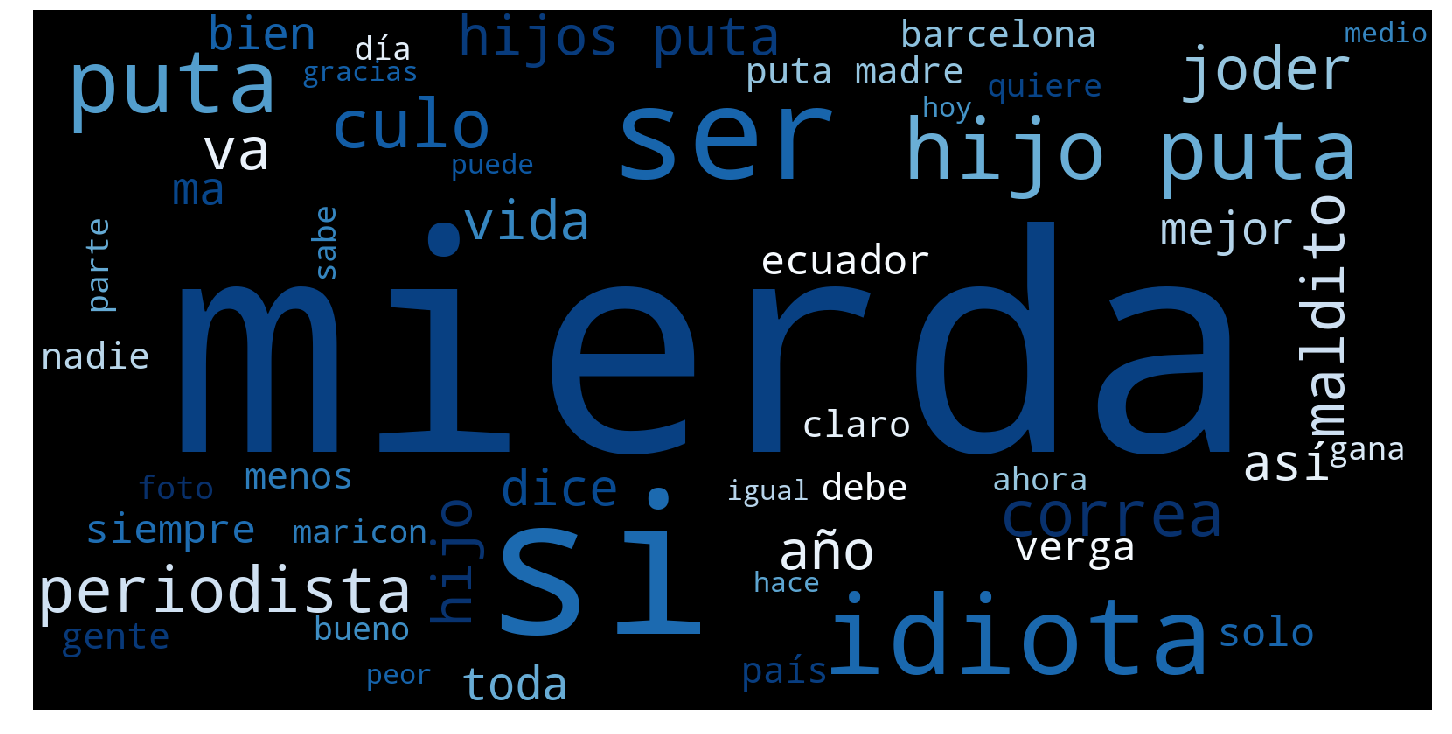

In [24]:
all_words = tweets['Tweet_lemmatized'].tolist()
cleaned_words = []
for i in all_words:
    for j in i:
            cleaned_words.append(j)

# Convierte  clean_words a una serie y cuenta las ocurrencias más frecuentes
cleaned_words_series = pd.Series(cleaned_words)
words_counts = cleaned_words_series.value_counts()
hashes = cleaned_words_series.values
hashes = hashes.tolist()

# Convierte la lista a un string con todas las palabras
hashes_words = " ".join(hashes)

# Genera la nube de palabras con las palabras más utilizadas
from wordcloud import WordCloud
wordcloud = WordCloud(width= 1600, height = 800, 
                      relative_scaling = 1.0, 
                      colormap = "Blues",
                     max_words = 50).generate(hashes_words)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


In [25]:
# Función que retorna el número de menciones del tweet
def mentions(lista):
    if lista[0]=='0':
        return 0
    else:
        return len(lista)
    
# Creación de una nueva columna con el número de menciones del tweet    
tweets['mentions']=tweets.user_mentions.apply(mentions)
tweets.head(10)

,id,screen_name,latitude,longitude,in_reply_to_status_id,text,timestamp,conversation_id,conversation_deep,url,...,extended,comment,user_mentions,Tweet_punct,sentiment,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized,mentions
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-01-28 16:10:53,1.632930e+17,LeninArtieda,NaN,NaN,NaN,bajaron de Ciudad Alfaro a Montecristi. Algun...,2012-01-28 16:10:53,1.632930e+17,1,https://www.twitter.com/LeninArtieda/status/16...,...,@DiegowMM bajaron de Ciudad Alfaro a Montecris...,NaN,[DiegowMM],bajaron de Ciudad Alfaro a Montecristi Alguno...,0.0000,"[, bajaron, de, ciudad, alfaro, a, montecristi...","[, bajaron, ciudad, alfaro, montecristi, queda...","[, bajaron, ciudad, alfaro, montecristi, queda...","[, ciudad, alfaro, montecristi, quedaron, escu...",1
2012-01-28 16:19:50,1.632952e+17,javi_300,NaN,NaN,1.632858e+17,Me parece raro que hayan planificado un show...,2012-01-28 16:19:50,1.632842e+17,4,https://www.twitter.com/javi_300/status/163295...,...,@LeninArtieda @JoseYcaza Me parece raro que ha...,NaN,"[LeninArtieda, JoseYcaza]",Me parece raro que hayan planificado un show...,0.0000,"[, me, parece, raro, que, hayan, planificado, ...","[, parece, raro, planificado, show, mismo, tie...","[, parec, raro, planificado, show, mismo, tiem...","[, parece, raro, planificado, show, mismo, tie...",2
2012-07-23 16:52:04,2.274460e+17,ElGuille1981,NaN,NaN,2.274399e+17,"jajaja estamos en la mierda, maldita llegada...",2012-07-23 16:52:04,2.274387e+17,3,https://www.twitter.com/ElGuille1981/status/22...,...,@andresitorres8 @aguschmer jajaja estamos en l...,NaN,"[andresitorres8, aguschmer]",jajaja estamos en la mierda maldita llegada ...,0.0000,"[, jajaja, estamos, en, la, mierda, maldita, l...","[, jajaja, mierda, maldita, llegada, ]","[, jajaja, mierda, maldita, llegada, ]","[, mierda, maldita, llegada, ]",2
2012-07-30 21:08:59,2.300474e+17,OmarVLuna,NaN,NaN,NaN,Bien Gongora!!!,2012-07-30 21:08:59,2.300474e+17,1,https://www.twitter.com/OmarVLuna/status/23004...,...,Bien Gongora!!!,NaN,[0],Bien Gongora,0.0000,"[bien, gongora]","[bien, gongora]","[bien, gongora]","[bien, gongora]",0
2012-08-12 23:33:07,2.347947e+17,Ceagd,NaN,NaN,2.347929e+17,RT Arroyo gana pelota a Giménez y Gol de Díaz...,2012-08-12 23:33:07,2.347929e+17,2,https://www.twitter.com/Ceagd/status/234794677...,...,RT @RobertoBonafont: Arroyo gana pelota a Gimé...,NaN,[RobertoBonafont:],RT Arroyo gana pelota a Giménez y Gol de Díaz...,0.0000,"[rt, arroyo, gana, pelota, a, giménez, y, gol,...","[arroyo, gana, pelota, giménez, gol, díaz, lej...","[arroyo, gana, pelota, giménez, gol, díaz, lej...","[arroyo, gana, pelota, giménez, gol, díaz, der...",1
2012-09-23 19:51:49,2.499593e+17,williamludena,NaN,NaN,2.499587e+17,Saludos hermano!,2012-09-23 19:51:49,2.499465e+17,7,https://www.twitter.com/williamludena/status/2...,...,@Pichi_Mendoza Saludos hermano!,NaN,[Pichi_Mendoza],Saludos hermano,0.0000,"[, saludos, hermano]","[, saludos, hermano]","[, saludo, hermano]","[, saludos, hermano]",1
2012-10-10 11:39:41,2.559960e+17,rhernandeztv,NaN,NaN,NaN,"Glad to hear fom you,",2012-10-10 11:39:41,2.559960e+17,1,https://www.twitter.com/rhernandeztv/status/25...,...,"Glad to hear fom you, @Begumdonmez",saludo,[Begumdonmez],Glad to hear fom you,0.4588,"[glad, to, hear, fom, you, ]","[glad, to, hear, fom, you, ]","[glad, to, hear, fom, you, ]","[glad, to, hear, fom, you, ]",1
2013-02-24 01:03:20,3.054830e+17,egasic,NaN,NaN,3.054825e+17,de q vale la libertadores si en el campeona...,2013-02-24 1:03:20,3.054825e+17,2,https://www.twitter.com/egasic/status/30548301...,...,@xaviercoellob @tononoboa @LuchoNoboaYcaza de ...,NaN,"[xaviercoellob, tononoboa, LuchoNoboaYcaza]",de q vale la libertadores si en el campeona...,0.0000,"[, de, q, vale, la, libertadores, si, en, el, ...","[, vale, libertadores, si, campeonato, stamos,...","[, vale, libertador, si, campeonato, stamo, n,...","[, vale, libertadores, si, campeonato, stamos,...",3
2013-04-11 12:30:24,3.223258e+17,ivonnelago,

In [26]:
# Eliminamos los espacios en blanco de los tweets
lista = hashes.copy()
lista = np.array(lista)
lista = lista[lista != ""]
lista = list(lista)
print(lista)

['ciudad', 'alfaro', 'montecristi', 'quedaron', 'escuchando', 'presidente', 'parece', 'raro', 'planificado', 'show', 'mismo', 'tiempo', 'sabatina', 'obvio', 'iban', 'ir', 'pa', 'alla', 'mierda', 'maldita', 'llegada', 'bien', 'gongora', 'arroyo', 'gana', 'pelota', 'giménez', 'gol', 'díaz', 'derechazo', 'memorable', 'memorable', 'saludos', 'hermano', 'glad', 'to', 'hear', 'fom', 'you', 'vale', 'libertadores', 'si', 'campeonato', 'stamos', 'n', 'mierda', 'castillejos', 'dsgracia', 'ser', 'estúpido', 'descriteriado', 'necesita', 'estudiar', 'ser', 'bueno', 'sinónimo', 'ser', 'idiota', 'ser', 'bueno', 'virtud', 'idiotas', 'entienden', 'ser', 'bueno', 'sinónimo', 'ser', 'idiota', 'ser', 'bueno', 'virtud', 'idiotas', 'entienden', 'da', 'esperes', 'cambio', 'recompensa', 'agradable', 'sorpresa', 'si', 'caigo', 'levantas', 'si', 'enredo', 'desatas', 'si', 'pierdo', 'rescatas', 'bendito', 'jesús', 'foto', 'tabla', 'ubicaciones', 'previo', 'última', 'fecha', 'eliminatoriassudamericanas', 'httptco

Text(0.5,1,'frequency of terms in Tweets')

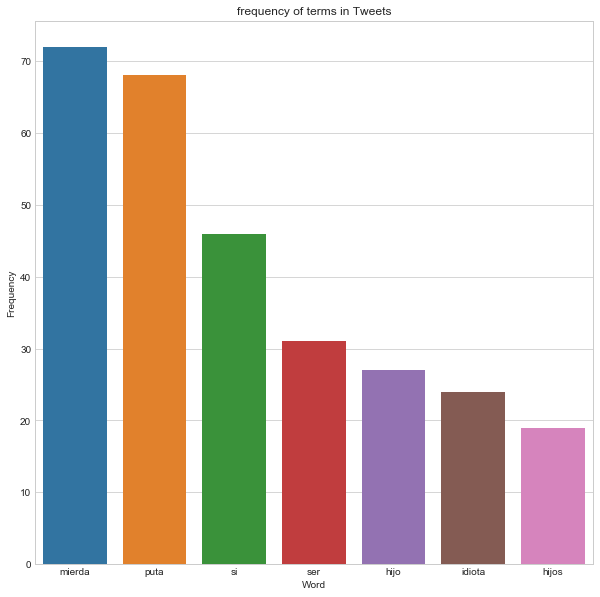

In [27]:
# Visualizamos la frecuencia de las palabras más usadas en todo el dataframe
word_dist = nltk.FreqDist(lista)
rslt = pd.DataFrame(word_dist.most_common(50),
                    columns=['Word', 'Frequency'])

plt.figure(figsize=(10,10))
sb.set_style("whitegrid")
ax = sb.barplot(x="Word",y="Frequency", data=rslt.head(7))
plt.title('frequency of terms in Tweets')

In [28]:
# Obtenemos las malas palabras más utilizadas
freq_words=rslt.Word[0:5].tolist()
del freq_words[2:4]
print(freq_words)

['mierda', 'puta', 'hijo']


In [29]:
# Función que retorna el número de malas palabras en el tweet
def bad_words(lista1):
    cnt=0
    lista2=freq_words
    for i in range(len(lista1)):
        for j in range(len(lista2)):
            if lista2[j] in lista1[i]:
                cnt+=1
    return cnt

            

Text(0.5,1,'Sentiment of tweets')

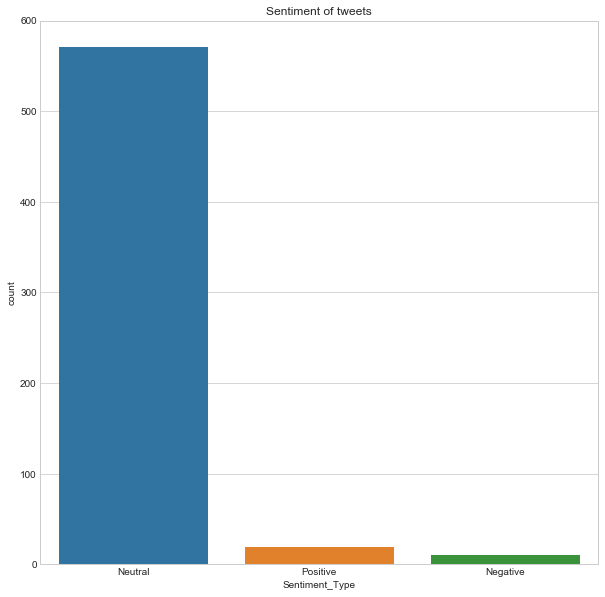

In [30]:
from textblob import TextBlob

bloblist_desc = list()

tweets_desc=tweets['Tweet_punct'].astype(str)
for row in tweets_desc:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    tweets_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['sentence','sentiment','polarity'])
    
#Función que etiqueta los tweets como positivo, negativo y neutral 
def f(tweets_polarity_desc):
    if tweets_polarity_desc['sentiment'] > 0:
        val = "Positive"
    elif tweets_polarity_desc['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val

tweets_polarity_desc['Sentiment_Type'] = tweets_polarity_desc.apply(f, axis=1)

# Muestra la frecuencia de cada sentimiento en el dataset
plt.figure(figsize=(10,10))
sb.set_style("whitegrid")
ax = sb.countplot(x="Sentiment_Type", data=tweets_polarity_desc)
plt.title('Sentiment of tweets')


In [31]:
#Creación de un nuevo dataset
Processed_tweets=tweets[['timestamp','screen_name','text','mentions','sentiment','Tweet_lemmatized','toxic','severe_toxic','obscene','threat','identity_hate','insult']].copy()
Processed_tweets.head()

,timestamp,screen_name,text,mentions,sentiment,Tweet_lemmatized,toxic,severe_toxic,obscene,threat,identity_hate,insult
timestamp,,,,,,,,,,,,
2012-01-28 16:10:53,2012-01-28 16:10:53,LeninArtieda,bajaron de Ciudad Alfaro a Montecristi. Algun...,1,0.0,"[, ciudad, alfaro, montecristi, quedaron, escu...",0,0,0,0,0,0
2012-01-28 16:19:50,2012-01-28 16:19:50,javi_300,Me parece raro que hayan planificado un show...,2,0.0,"[, parece, raro, planificado, show, mismo, tie...",0,0,0,0,0,0
2012-07-23 16:52:04,2012-07-23 16:52:04,ElGuille1981,"jajaja estamos en la mierda, maldita llegada...",2,0.0,"[, mierda, maldita, llegada, ]",0,0,0,0,0,1
2012-07-30 21:08:59,2012-07-30 21:08:59,OmarVLuna,Bien Gongora!!!,0,0.0,"[bien, gongora]",0,0,0,0,0,0
2012-08-12 23:33:07,2012-08-12 23:33:07,Ceagd,RT Arroyo gana pelota a Giménez y Gol de Díaz...,1,0.0,"[arroyo, gana, pelota, giménez, gol, díaz, der...",0,0,0,0,0,0


In [32]:
#Visualizamos caracterísitcas en común de los tweets con la palabra definida a continuación
Processed_tweets[Processed_tweets['Tweet_lemmatized'].astype(str).str.contains("mierda")]

,timestamp,screen_name,text,mentions,sentiment,Tweet_lemmatized,toxic,severe_toxic,obscene,threat,identity_hate,insult
timestamp,,,,,,,,,,,,
2012-07-23 16:52:04,2012-07-23 16:52:04,ElGuille1981,"jajaja estamos en la mierda, maldita llegada...",2,0.0000,"[, mierda, maldita, llegada, ]",0,0,0,0,0,1
2013-02-24 01:03:20,2013-02-24 1:03:20,egasic,de q vale la libertadores si en el campeona...,3,0.0000,"[, vale, libertadores, si, campeonato, stamos,...",1,0,0,0,0,0
2014-12-22 04:10:42,2014-12-22 4:10:42,Lucho_Patucho,"vago de mierda, periodista de a centavo, vend...",2,0.0000,"[, vago, mierda, periodista, centavo, vendido,...",0,0,0,0,0,1
2016-05-18 16:16:14,2016-05-18 16:16:14,HugoVer89988101,"zorra hp deja d joder, ers así no tiens ni Di...",1,-0.2960,"[, zorra, hp, joder, er, así, tiens, dios, ley...",0,0,1,0,0,0
2016-08-13 21:49:15,2016-08-13 21:49:15,elrobin0194,"Ávila otro alemán, solo fingiendo, en el piso...",1,0.0000,"[, ávila, alemán, solo, fingiendo, piso, pas, ...",0,1,0,0,0,0
2016-09-23 17:42:49,2016-09-23 17:42:49,Wpinto14,dedícate a ir al estadio hincha de Twitte...,5,0.0000,"[, dedícate, ir, estadio, hincha, twitter, feo...",0,1,0,0,0,0
2016-10-25 19:18:50,2016-10-25 19:18:50,turcacat,Cuando tengas ganas de mandar todo a la mierda...,0,0.0000,"[ganas, mandar, mierda, recuerda, vida, baile,...",1,0,0,0,0,0
2017-01-12 18:37:29,2017-01-12 18:37:29,faviogovea,lo que quieren es encontrar un Cojudo para t...,2,0.0000,"[, quieren, encontrar, cojudo, tirarle, muerto...",0,0,0,0,0,1
2017-02-05 00:12:14,2017-02-05 0:12:14,solounidolo,por gente como estamos en la mierda.. #Miser...,2,0.0000,"[, gente, mierda, miserablemalnacidohdp]",1,0,0,0,0,0


In [33]:
#Visualizamos caracterísitcas en común de los tweets etiquetados como tóxicos
Processed_tweets[Processed_tweets.toxic==1]

,timestamp,screen_name,text,mentions,sentiment,Tweet_lemmatized,toxic,severe_toxic,obscene,threat,identity_hate,insult
timestamp,,,,,,,,,,,,
2013-02-24 01:03:20,2013-02-24 1:03:20,egasic,de q vale la libertadores si en el campeona...,3,0.0000,"[, vale, libertadores, si, campeonato, stamos,...",1,0,0,0,0,0
2015-05-21 16:24:01,2015-05-21 16:24:01,arquique,eso nunca perro pecho frío!!!,1,0.0000,"[, nunca, perro, pecho, frío]",1,0,0,0,0,0
2016-01-31 01:03:32,2016-01-31 1:03:32,eddymoran11,que manera de joder este viejo a barcelona a...,2,0.0000,"[, manera, joder, viejo, barcelona, apuesto, h...",1,0,0,0,0,0
2016-07-22 02:44:23,2016-07-22 2:44:23,VelezJohann,afloja ese culo,1,0.0000,"[, culo]",1,0,0,0,0,0
2016-07-27 19:27:56,2016-07-27 19:27:56,mhmnat1,que se vayan a Turquía entonces y no jodan po...,1,-0.2960,"[, vayan, turquía, entonces, jodan, acá]",1,0,0,0,0,0
2016-10-25 19:18:50,2016-10-25 19:18:50,turcacat,Cuando tengas ganas de mandar todo a la mierda...,0,0.0000,"[ganas, mandar, mierda, recuerda, vida, baile,...",1,0,0,0,0,0
2017-01-01 02:15:24,2017-01-01 2:15:24,Marito2200,el tweet estúpido del año.,1,0.0000,"[, tweet, estúpido, año]",1,0,0,0,0,0
2017-02-05 00:12:14,2017-02-05 0:12:14,solounidolo,por gente como estamos en la mierda.. #Miser...,2,0.0000,"[, gente, mierda, miserablemalnacidohdp]",1,0,0,0,0,0
2017-02-25 18:38:10,2017-02-25 18:38:10,marcopaezc,Eres una puerca.,1,0.0000,"[, puerca]",1,0,0,0,0,1


In [34]:
#Creacion de una nueva columna que contiene la cantidad de malas palabras en el tweet
Processed_tweets['num_bad_words']=Processed_tweets.Tweet_lemmatized.apply(bad_words)
Processed_tweets.head(20)

,timestamp,screen_name,text,mentions,sentiment,Tweet_lemmatized,toxic,severe_toxic,obscene,threat,identity_hate,insult,num_bad_words
timestamp,,,,,,,,,,,,,
2012-01-28 16:10:53,2012-01-28 16:10:53,LeninArtieda,bajaron de Ciudad Alfaro a Montecristi. Algun...,1,0.0000,"[, ciudad, alfaro, montecristi, quedaron, escu...",0,0,0,0,0,0,0
2012-01-28 16:19:50,2012-01-28 16:19:50,javi_300,Me parece raro que hayan planificado un show...,2,0.0000,"[, parece, raro, planificado, show, mismo, tie...",0,0,0,0,0,0,0
2012-07-23 16:52:04,2012-07-23 16:52:04,ElGuille1981,"jajaja estamos en la mierda, maldita llegada...",2,0.0000,"[, mierda, maldita, llegada, ]",0,0,0,0,0,1,1
2012-07-30 21:08:59,2012-07-30 21:08:59,OmarVLuna,Bien Gongora!!!,0,0.0000,"[bien, gongora]",0,0,0,0,0,0,0
2012-08-12 23:33:07,2012-08-12 23:33:07,Ceagd,RT Arroyo gana pelota a Giménez y Gol de Díaz...,1,0.0000,"[arroyo, gana, pelota, giménez, gol, díaz, der...",0,0,0,0,0,0,0
2012-09-23 19:51:49,2012-09-23 19:51:49,williamludena,Saludos hermano!,1,0.0000,"[, saludos, hermano]",0,0,0,0,0,0,0
2012-10-10 11:39:41,2012-10-10 11:39:41,rhernandeztv,"Glad to hear fom you,",1,0.4588,"[glad, to, hear, fom, you, ]",0,0,0,0,0,0,0
2013-02-24 01:03:20,2013-02-24 1:03:20,egasic,de q vale la libertadores si en el campeona...,3,0.0000,"[, vale, libertadores, si, campeonato, stamos,...",1,0,0,0,0,0,1
2013-04-11 12:30:24,2013-04-11 12:30:24,ivonnelago,Para ser estúpido y descriteriado no se necesi...,0,-0.2960,"[ser, estúpido, descriteriado, necesita, estud...",0,0,0,0,0,1,0


In [35]:
# Export el dataset creado
Processed_tweets.to_csv('toxic_tweets.csv')

# Another visualization of frecuent words in tweets

## We will join all the tweets in a corpus and search for topics apllying TFIDF model

In [46]:
#Construimos el corpus
corpus=[]
a=[]
for i in range(len(tweets['Tweet_punct'])):
        a=tweets['Tweet_punct'][i]
        corpus.append(a)
import gensim
import logging
import tempfile

TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

from gensim import corpora
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "C:\Users\LENOVO\AppData\Local\Temp" will be used to save temporary dictionary and corpus.


In [47]:
from nltk.corpus import stopwords
from string import punctuation
import os

# Remueve las palabras comunes
list1 = ['RT','rt','d','x','q','bla','ab','xq','ma']
stoplist = stopwords.words('spanish') + list(punctuation) + list1

texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]
dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'tweets.dict'))  # Guarda el diccionario para futuras referencias
#print(dictionary)
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'tweet.mm'), corpus)
from gensim import corpora, models, similarities
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus] 

In [60]:
#Definimos el total de tópicos que deseamos usar
total_topics = 4
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] 
lda.show_topics(total_topics,5)
from collections import OrderedDict

#Visualizando el dataframe con los tópicos obtenidos
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)
df_lda

C:\Users\LENOVO\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\LENOVO\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\LENOVO\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

C:\Users\LENOVO\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\LENOVO\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\LENOVO\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

C:\Users\LENOVO\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\LENOVO\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\LENOVO\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

C:\Users\LENOVO\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\LENOVO\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\LENOVO\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

C:\Users\LENOVO\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\LENOVO\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\LENOVO\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

C:\Users\LENOVO\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\LENOVO\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\LENOVO\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

(67, 4)
(4, 67)


,ahora,así,año,barcelona,bien,bueno,cara,claro,correa,culo,...,ser,si,siempre,solo,tiempo,tipo,toda,va,verga,vida
0,0.000000,0.002348,0.000000,0.002635,0.000000,0.000000,0.000000,0.000000,0.002322,0.000000,...,0.006728,0.011559,0.000000,0.001848,0.000000,0.000000,0.000000,0.002338,0.000000,0.000000
1,0.000000,0.002339,0.001896,0.000000,0.000000,0.000000,0.004448,0.000000,0.000000,0.002198,...,0.004505,0.010800,0.003246,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002003
2,0.002015,0.000000,0.000000,0.000000,0.000000,0.002992,0.000000,0.000000,0.005081,0.005615,...,0.005742,0.002840,0.000000,0.000000,0.000000,0.002598,0.002591,0.002147,0.000000,0.000000
3,0.001716,0.000000,0.001759,0.000000,0.002602,0.000000,0.000000,0.003511,0.000000,0.000000,...,0.000000,0.000000,0.001980,0.002522,0.001972,0.000000,0.000000,0.000000,0.003188,0.003524


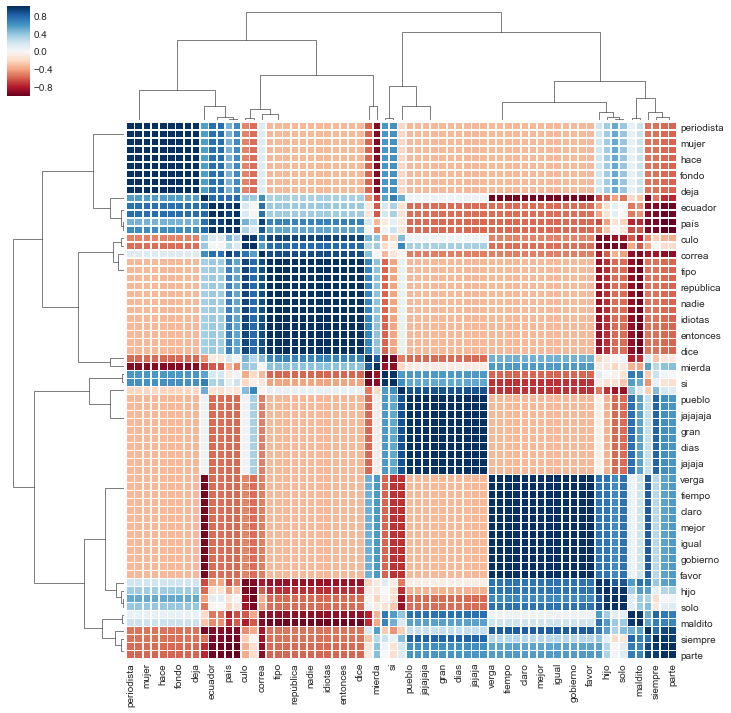

In [61]:
#Hacemos un gráfico de correlación entre cada uno de las palabras obtenidas
g=sb.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [62]:
#Realizamos la visualización interactiva de los tópicos encontrados con su respectiva relevancia
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
1      62.441647        1       1   93.329247  -73.071129
2      12.520284        1       2  -36.246910 -297.190857
3      12.519934        1       3  -83.514465 -120.345322
0      12.518138        1       4  140.596802 -249.916611, topic_info=     Category      Freq        Term     Total  loglift  logprob
term                                                           
22    Default  6.000000      mierda  6.000000  30.0000  30.0000
152   Default  5.000000        puta  5.000000  29.0000  29.0000
46    Default  5.000000          si  5.000000  28.0000  28.0000
182   Default  1.000000        hijo  1.000000  27.0000  27.0000
53    Default  2.000000         ser  2.000000  26.0000  26.0000
549   Default  1.000000        culo  1.000000  25.0000  25.0000
240   Default  0.000000      correa  0.000000  24.0000  24.0000
793   Default  0.000000         hoy  0.000000  23.0000  23.0000
598   Default  0.000000        deja  0.000000  22.0000  22.0000
1075  Default  0.000000       claro  0.000000  21.0000  21.0000
540   Default  1.000000       joder  1.000000  20.0000  20.0000
100   Default  1.000000        vida  1.000000  19.0000  19.0000
475   Default  1.000000       verga  1.000000  18.0000  18.0000
1900  Default  0.000000         gay  0.000000  17.0000  17.0000
662   Default  0.000000         mas  0.000000  16.0000  16.0000
222   Default  0.000000  periodista  0.000000  15.0000  15.0000
993   Default  0.000000     ecuador  0.000000  14.0000  14.0000
755   Default  1.000000       madre  1.000000  13.0000  13.0000
135   Default  0.000000        hace  0.000000  12.0000  12.0000
1122  Default  0.000000        país  0.000000  11.0000  11.0000
1181  Default  0.000000        tipo  0.000000  10.0000  10.0000
54    Default  0.000000       bueno  0.000000   9.0000   9.0000
1097  Default  0.000000        dice  0.000000   8.0000   8.0000
524   Default  0.000000       mejor  0.000000   7.0000   7.0000
9     Default  0.000000          ir  0.000000   6.0000   6.0000
656   Default  0.000000          va  0.000000   5.0000   5.0000
89    Default  0.000000    ladrones  0.000000   4.0000   4.0000
325   Default  0.000000       menos  0.000000   3.0000   3.0000
712   Default  0.000000        solo  0.000000   2.0000   2.0000
268   Default  0.000000       igual  0.000000   1.0000   1.0000
...       ...       ...         ...       ...      ...      ...
135    Topic4  0.215961        hace  0.544608   1.1530  -5.8516
1596   Topic4  0.123352    haciendo  0.250875   1.3681  -6.4116
222    Topic4  0.245239  periodista  0.724248   0.9951  -5.7245
46     Topic4  0.868175          si  5.205698   0.2869  -4.4603
182    Topic4  0.431077        hijo  1.817416   0.6391  -5.1604
89     Topic4  0.174392    ladrones  0.455863   1.1171  -6.0654
53     Topic4  0.505365         ser  2.729658   0.3913  -5.0014
152    Topic4  0.785352        puta  5.942794   0.0542  -4.5606
662    Topic4  0.220852         mas  0.729896   0.8826  -5.8292
993    Topic4  0.213484     ecuador  0.696640   0.8953  -5.8631
798    Topic4  0.142394       mujer  0.349410   1.1803  -6.2681
538    Topic4  0.197913   barcelona  0.757973   0.7352  -5.9389
1122   Topic4  0.164327        país  0.539618   0.8890  -6.1248
22     Topic4  0.502917      mierda  6.317160  -0.4526  -5.0063
540    Topic4  0.219701       joder  1.101001   0.4663  -5.8344
1306   Topic4  0.133749        boca  0.409562   0.9589  -6.3307
157    Topic4  0.134080    partidos  0.413683   0.9513  -6.3283
459    Topic4  0.133979       según  0.413818   0.9503  -6.3290
642    Topic4  0.133789      cuenca  0.414317   0.9476  -6.3304
841    Topic4  0.133037      carlos  0.415589   0.9389  -6.3361
488    Topic4  0.123528          ec  0.350520   1.0350  -6.4102
656    Topic4  0.175628          va  0.892228   0.4526  -6.0583
1453   Topic4  0.119281       tanta  0.328465   1.0650  -6.4452
240    Topic4  0.174430  